In [6]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Paths
ROOT = Path.cwd().parent
DATASET_PATH = ROOT / 'reports' / 'dataframes' / 'multiclass_dataset.csv'

print(f"Loading dataset from: {DATASET_PATH}")
assert DATASET_PATH.exists(), f"Dataset not found: {DATASET_PATH}"

df = pd.read_csv(DATASET_PATH)
print(f"Loaded {len(df):,} rows")
df.head(3)

Loading dataset from: c:\PythonProjects\rl_reserve_markets\upreg_classify\reports\dataframes\multiclass_dataset.csv
Loaded 38,007 rows


,NO2-DE,NO2-DK1,NO2-GB,NO2-NL,NO2-NO1,NO2-NO5,RegLag-4,RegLagCat-4,RegLag-6,RegLagCat-6,...,Persistency x DA Scarcity,PersistencyDown x DA Scarcity,Persistency x aFRR Price,PersistencyDown x aFRR Price,ID Price 3 - Day Ahead Price,aFRR_ActDirNum-4,aFRR_ActDirNum-6,aFRR_ActDirNum-8,aFRR Activation x mFRR Activation -4,aFRR Activation x mFRR Activation -6
0,0,242.0,310.0,13.0,1973.0,25.0,0,none,0,none,...,0,0,0.0,0.000000,-2.46,0,0,0,0,0
1,0,242.0,310.0,13.0,1973.0,25.0,0,none,0,none,...,0,0,0.0,0.000000,-2.46,0,0,0,0,0
2,0,242.0,310.0,13.0,1973.0,25.0,0,none,0,none,...,0,0,0.0,14.008824,-2.46,0,0,0,0,0


In [7]:
# Identify the label column (RegClass+4)
label_col = 'RegClass+4'
if label_col not in df.columns:
    # Fallback: look for any column starting with 'RegClass'
    label_candidates = [c for c in df.columns if c.startswith('RegClass')]
    if label_candidates:
        label_col = label_candidates[0]
    else:
        raise ValueError("Could not find label column (RegClass+4 or similar)")

print(f"Using label column: {label_col}")

# Count class distribution
counts = df[label_col].value_counts()
total = len(df)
percentages = (counts / total * 100).round(2)

summary = pd.DataFrame({
    'Class': counts.index,
    'Count': counts.values,
    'Percentage': percentages.values
}).sort_values('Count', ascending=False).reset_index(drop=True)

display(Markdown('## Class Distribution Summary'))
display(summary)

# Calculate imbalance ratio (majority / minority)
max_count = counts.max()
min_count = counts.min()
imbalance_ratio = max_count / min_count
print(f"\nImbalance ratio (majority/minority): {imbalance_ratio:.2f}:1")

Using label column: RegClass+4


## Class Distribution Summary

,Class,Count,Percentage
0,none,19593,51.55
1,down,11509,30.28
2,up,6905,18.17



Imbalance ratio (majority/minority): 2.84:1


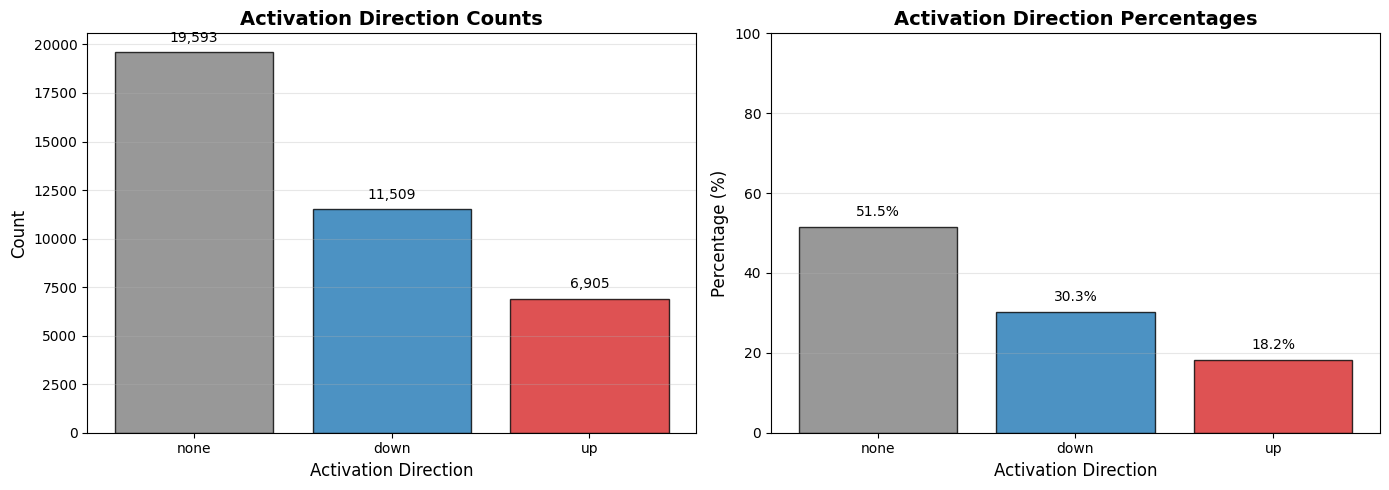

In [8]:
# Bar plot with counts and percentages
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Counts
colors = {'up': '#d62728', 'down': '#1f77b4', 'none': '#7f7f7f'}
ordered_classes = ['none', 'down', 'up']  # Most to least common (typically)
plot_order = [c for c in ordered_classes if c in counts.index]
plot_colors = [colors.get(c, '#2ca02c') for c in plot_order]

ax1.bar(plot_order, [counts[c] for c in plot_order], color=plot_colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xlabel('Activation Direction', fontsize=12)
ax1.set_title('Activation Direction Counts', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, cls in enumerate(plot_order):
    count = counts[cls]
    ax1.text(i, count + total*0.01, f'{count:,}', ha='center', va='bottom', fontsize=10)

# Percentages
ax2.bar(plot_order, [percentages[c] for c in plot_order], color=plot_colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_xlabel('Activation Direction', fontsize=12)
ax2.set_title('Activation Direction Percentages', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 100)
for i, cls in enumerate(plot_order):
    pct = percentages[cls]
    ax2.text(i, pct + 2, f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

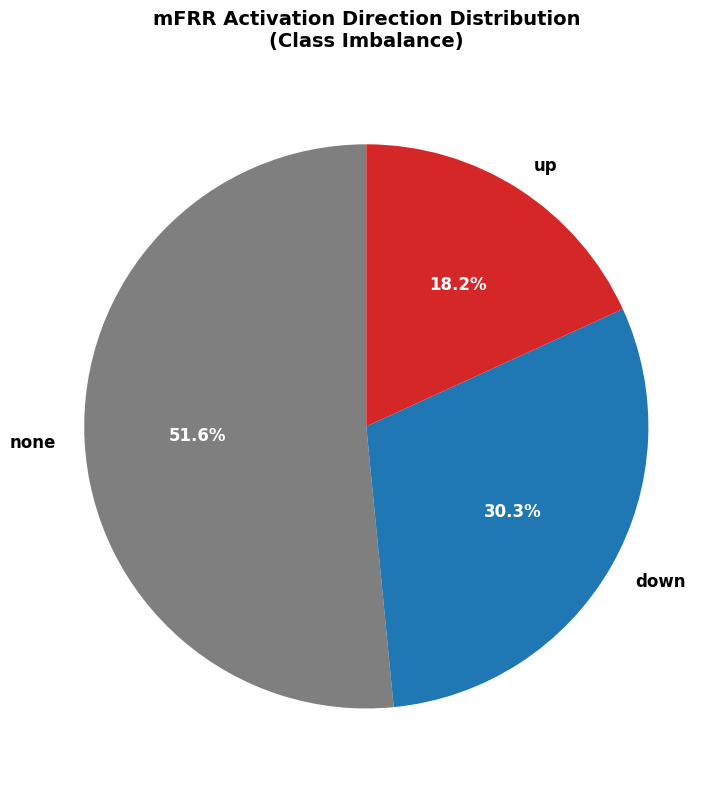


Dataset: 38,007 total observations
Imbalance ratio: 2.84:1
Majority class: none (19,593 samples, 51.5%)
Minority class: up (6,905 samples, 18.2%)


In [9]:
# Pie chart with imbalance visualization
fig, ax = plt.subplots(figsize=(8, 8))

wedges, texts, autotexts = ax.pie(
    [counts[c] for c in plot_order],
    labels=plot_order,
    colors=plot_colors,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12, 'weight': 'bold'}
)

for autotext in autotexts:
    autotext.set_color('white')

ax.set_title('mFRR Activation Direction Distribution\n(Class Imbalance)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"\n{'='*50}")
print(f"Dataset: {len(df):,} total observations")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"Majority class: {counts.idxmax()} ({counts.max():,} samples, {percentages.max():.1f}%)")
print(f"Minority class: {counts.idxmin()} ({counts.min():,} samples, {percentages.min():.1f}%)")
print(f"{'='*50}")

In [10]:
# Optional: Time series view of class distribution over time
# (if Time column exists and is parseable)
if 'Time' in df.columns:
    df_ts = df.copy()
    df_ts['Time'] = pd.to_datetime(df_ts['Time'], errors='coerce')
    df_ts = df_ts.dropna(subset=['Time'])
    
    if len(df_ts) > 0:
        df_ts = df_ts.set_index('Time').sort_index()
        
        # Monthly class counts
        monthly = df_ts.groupby([pd.Grouper(freq='M'), label_col]).size().unstack(fill_value=0)
        
        fig, ax = plt.subplots(figsize=(14, 6))
        for cls in plot_order:
            if cls in monthly.columns:
                ax.plot(monthly.index, monthly[cls], marker='o', label=cls, color=colors.get(cls, '#2ca02c'), linewidth=2)
        
        ax.set_xlabel('Month', fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        ax.set_title('Monthly Activation Direction Counts Over Time', fontsize=14, fontweight='bold')
        ax.legend(title='Class', fontsize=11)
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("Time column found but could not parse dates.")
else:
    print("No 'Time' column found; skipping time series view.")

No 'Time' column found; skipping time series view.
